In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Training on CPU.")

GPU is available and configured.


In [4]:
# !unzip /content/drive/MyDrive/Major_Project_dataset/newPlantDisease.zip -d /content/drive/MyDrive/Major_Project_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Major_Project_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: /content/drive/MyDrive/Major_Project_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: /content/drive/MyDrive/Major_Project_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: /content/drive/MyDrive/Major_Project_dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/drive/MyDrive/Major_Project_data

In [5]:
# import os
# import shutil
# import random

# def split_validation_data(val_directory, output_val_directory, output_test_directory):
#     os.makedirs(output_val_directory, exist_ok=True)
#     os.makedirs(output_test_directory, exist_ok=True)

#     for label in os.listdir(val_directory):
#         label_path = os.path.join(val_directory, label)

#         if os.path.isdir(label_path):
#             images = [f for f in os.listdir(label_path) if f.endswith(('.jpg', '.JPG', '.png', '.PNG'))]
#             random.shuffle(images)
#             split_index = len(images) // 2
#             val_images = images[:split_index]
#             test_images = images[split_index:]

#             os.makedirs(os.path.join(output_val_directory, label), exist_ok=True)
#             os.makedirs(os.path.join(output_test_directory, label), exist_ok=True)

#             for img in val_images:
#                 shutil.copy(os.path.join(label_path, img), os.path.join(output_val_directory, label, img))
#             for img in test_images:
#                 shutil.copy(os.path.join(label_path, img), os.path.join(output_test_directory, label, img))

#             print(f"Processed '{label}' - Val count: {len(val_images)}, Test count: {len(test_images)}")

# val_directory = '/content/drive/MyDrive/Major_Project_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
# output_val_directory = '/content/drive/MyDrive/Major_Project_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/newVal'
# output_test_directory = '/content/drive/MyDrive/Major_Project_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/newTest'

# split_validation_data(val_directory, output_val_directory, output_test_directory)

Processed 'Apple___Apple_scab' - Val count: 252, Test count: 252
Processed 'Apple___Black_rot' - Val count: 248, Test count: 249
Processed 'Apple___Cedar_apple_rust' - Val count: 220, Test count: 220
Processed 'Apple___healthy' - Val count: 251, Test count: 251
Processed 'Blueberry___healthy' - Val count: 227, Test count: 227
Processed 'Cherry_(including_sour)___Powdery_mildew' - Val count: 210, Test count: 211
Processed 'Cherry_(including_sour)___healthy' - Val count: 228, Test count: 228
Processed 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' - Val count: 205, Test count: 205
Processed 'Corn_(maize)___Common_rust_' - Val count: 238, Test count: 239
Processed 'Corn_(maize)___Northern_Leaf_Blight' - Val count: 238, Test count: 239
Processed 'Corn_(maize)___healthy' - Val count: 232, Test count: 233
Processed 'Grape___Black_rot' - Val count: 236, Test count: 236
Processed 'Grape___Esca_(Black_Measles)' - Val count: 240, Test count: 240
Processed 'Grape___Leaf_blight_(Isariopsis_L

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, models
import cv2
import os
import numpy as np

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Training on CPU.")

GPU is available and configured.


In [8]:
def preprocess_image(image):
    image_resized = cv2.resize(image, (380, 380))
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(gray)
    image_final = cv2.merge([clahe_applied, clahe_applied, clahe_applied])

    return image_final


In [9]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical

In [12]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_directory, batch_size, target_size=(380, 380),
                 shuffle=True, preprocessing_function=None, exclude_labels=None,
                 split_data=False, split_ratio=0.5, verbose=1, **kwargs):
        super().__init__(**kwargs)
        self.image_directory = image_directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.preprocessing_function = preprocessing_function
        self.exclude_labels = exclude_labels if exclude_labels else []  # Exclusion list
        self.verbose = verbose
        self.image_paths = []
        self.labels = []
        self.crop_names = []
        self.class_indices = {}
        self._prepare_data()

        if split_data:
            self.image_paths, self.test_image_paths, self.labels, self.test_labels, self.crop_names, self.test_crop_names = self.split_data(split_ratio)
        else:
            self.test_image_paths = []
            self.test_labels = []
            self.test_crop_names = []

        self.label_encoder = LabelEncoder()
        self.crop_encoder = LabelEncoder()

        self.labels_encoded = self.label_encoder.fit_transform(self.labels)
        self.crop_encoded = self.crop_encoder.fit_transform(self.crop_names)

        self.onehot_crop_encoder = OneHotEncoder(sparse_output=False)
        self.crop_onehot_encoded = self.onehot_crop_encoder.fit_transform(self.crop_encoded.reshape(-1, 1))

        self.on_epoch_end()

    def split_data(self, split_ratio):
        """Split the data into training and testing sets."""
        unique_labels = np.unique(self.labels)
        image_paths, test_image_paths, labels, test_labels = train_test_split(
            self.image_paths, self.labels, test_size=split_ratio, random_state=42, stratify=self.labels
        )

        crop_names = [os.path.basename(os.path.dirname(path)) for path in image_paths]
        test_crop_names = [os.path.basename(os.path.dirname(path)) for path in test_image_paths]

        return image_paths, test_image_paths, labels, test_labels, crop_names, test_crop_names

    def _prepare_data(self):
        """Extract image paths, labels, and crop names, excluding specified labels."""
        for root, dirs, files in os.walk(self.image_directory):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".JPG"):
                    path = os.path.join(root, file)
                    label = os.path.basename(root)
                    crop_name = label.split('__')[0]

                    if crop_name not in self.exclude_labels:
                        self.image_paths.append(path)
                        self.labels.append(label)
                        self.crop_names.append(crop_name)

        unique_labels = np.unique(self.labels)
        self.class_indices = {label: index for index, label in enumerate(unique_labels)}

        if self.verbose > 0:
            print(f"Total images found: {len(self.image_paths)}")
            print(f"Unique labels (classes): {len(unique_labels)}")
            print("Class indices:", self.class_indices)

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels_encoded[index * self.batch_size:(index + 1) * self.batch_size]
        batch_crop_names = self.crop_onehot_encoded[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        for path in batch_image_paths:
            image = load_img(path, target_size=self.target_size)
            if self.preprocessing_function:
                image = self.preprocessing_function(image)
            image = img_to_array(image) / 255.0

            images.append(image)

        images = np.array(images)
        batch_labels = to_categorical(batch_labels, num_classes=len(self.class_indices))
        batch_crop_names = np.array(batch_crop_names)

        if self.verbose > 1:
            print(f"Batch {index + 1}/{self.__len__()} - Loaded images: {batch_image_paths}")
            print(f"Batch labels: {batch_labels}")
            print(f"Input shapes: {images.shape}, Crop shapes: {batch_crop_names.shape}, Label shapes: {batch_labels.shape}")
        return (images, batch_crop_names), batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = [self.image_paths[i] for i in indices]
            self.labels_encoded = self.labels_encoded[indices]
            self.crop_onehot_encoded = self.crop_onehot_encoded[indices]

In [27]:
exclude_classes = ['Blueberry', 'Orange', 'Raspberry', 'Soybean', 'Squash']

train_gen = CustomDataGenerator(image_directory='/content/drive/MyDrive/Major_Project_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train', batch_size=32,
                                 exclude_labels=exclude_classes)

valid_gen = CustomDataGenerator(image_directory='/content/drive/MyDrive/Major_Project_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/newVal', batch_size=32,
                                 exclude_labels=exclude_classes)

test_gen = CustomDataGenerator(image_directory='/content/drive/MyDrive/Major_Project_dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/newTest', batch_size=32,
                                 exclude_labels=exclude_classes)

Total images found: 60930
Unique labels (classes): 33
Class indices: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Cherry_(including_sour)___Powdery_mildew': 4, 'Cherry_(including_sour)___healthy': 5, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 6, 'Corn_(maize)___Common_rust_': 7, 'Corn_(maize)___Northern_Leaf_Blight': 8, 'Corn_(maize)___healthy': 9, 'Grape___Black_rot': 10, 'Grape___Esca_(Black_Measles)': 11, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 12, 'Grape___healthy': 13, 'Peach___Bacterial_spot': 14, 'Peach___healthy': 15, 'Pepper,_bell___Bacterial_spot': 16, 'Pepper,_bell___healthy': 17, 'Potato___Early_blight': 18, 'Potato___Late_blight': 19, 'Potato___healthy': 20, 'Strawberry___Leaf_scorch': 21, 'Strawberry___healthy': 22, 'Tomato___Bacterial_spot': 23, 'Tomato___Early_blight': 24, 'Tomato___Late_blight': 25, 'Tomato___Leaf_Mold': 26, 'Tomato___Septoria_leaf_spot': 27, 'Tomato___Spider_mites Two-spotted_

# Validation dataset

{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Cherry_(including_sour)___Powdery_mildew', 5: 'Cherry_(including_sour)___healthy', 6: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 7: 'Corn_(maize)___Common_rust_', 8: 'Corn_(maize)___Northern_Leaf_Blight', 9: 'Corn_(maize)___healthy', 10: 'Grape___Black_rot', 11: 'Grape___Esca_(Black_Measles)', 12: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 13: 'Grape___healthy', 14: 'Peach___Bacterial_spot', 15: 'Peach___healthy', 16: 'Pepper,_bell___Bacterial_spot', 17: 'Pepper,_bell___healthy', 18: 'Potato___Early_blight', 19: 'Potato___Late_blight', 20: 'Potato___healthy', 21: 'Strawberry___Leaf_scorch', 22: 'Strawberry___healthy', 23: 'Tomato___Bacterial_spot', 24: 'Tomato___Early_blight', 25: 'Tomato___Late_blight', 26: 'Tomato___Leaf_Mold', 27: 'Tomato___Septoria_leaf_spot', 28: 'Tomato___Spider_mites Two-spotted_spider_mite', 29: 'Tomato___Target_Spot', 30: 'Tomato___Tomato_Ye

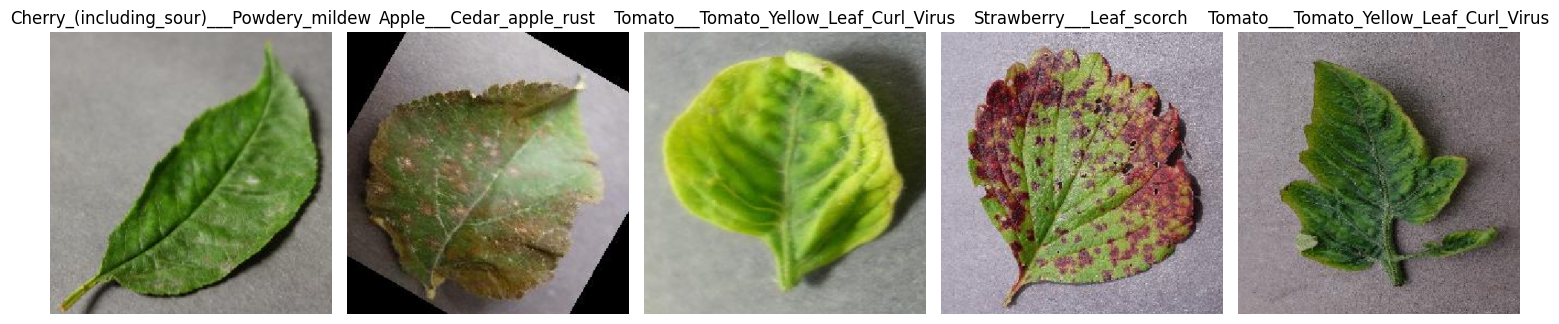

In [28]:
import matplotlib.pyplot as plt

class_indices = train_gen.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
print(index_to_label)
def visualize_predictions_with_filenames(test_generator, num_images=5):
    test_gen_iter = iter(test_generator)
    (images, crop_names), true_labels = next(test_gen_iter)

    images = images[:num_images]
    crop_names = crop_names[:num_images]
    true_labels = true_labels[:num_images]

    true_labels_flat = np.argmax(true_labels, axis=1)

    label_encoder = test_generator.label_encoder
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])

        true_label = label_encoder.inverse_transform([true_labels_flat[i]])[0]
        plt.title(true_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions_with_filenames(valid_gen, num_images=5)

# Train dataset

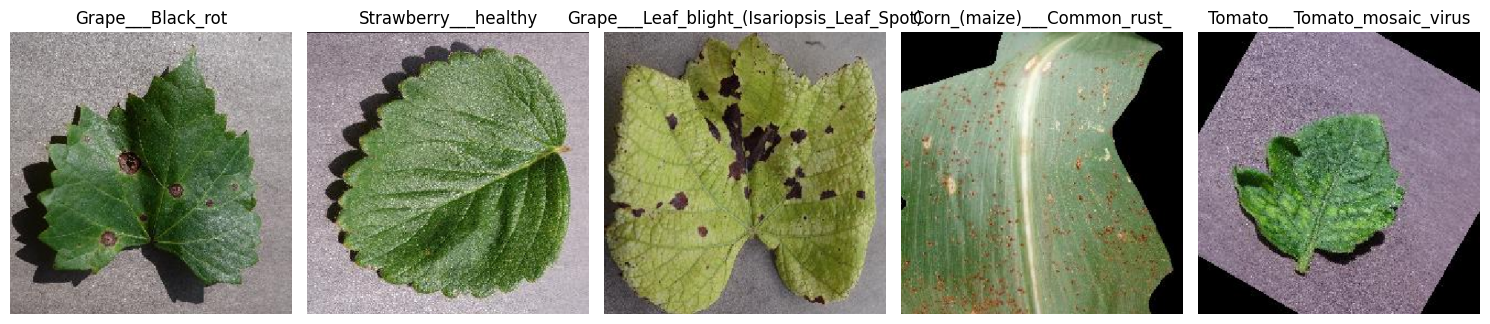

In [29]:
visualize_predictions_with_filenames(train_gen, num_images=5)

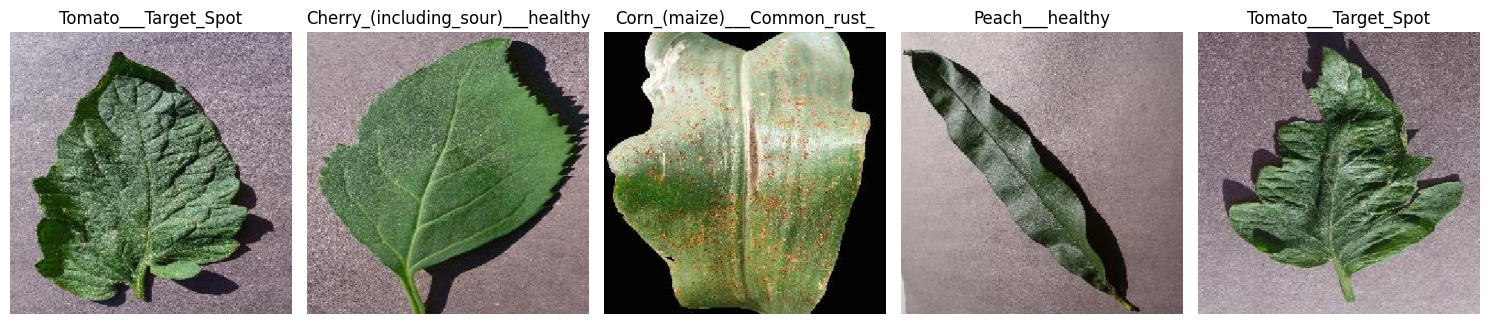

In [30]:
visualize_predictions_with_filenames(test_gen, num_images=5)

In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf

IMG_SIZE = (380, 380)
NUM_CLASSES = 33
NUM_CROPS = 9

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
total_layers = len(base_model.layers)
trainable_layers_count = int(total_layers * 0.60)

print(f"Unfreezed number of layers are {trainable_layers_count} and total number of layers is {total_layers}")

for layer in base_model.layers[:total_layers - trainable_layers_count]:
    layer.trainable = False


image_input = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = base_model(image_input)
x = GlobalAveragePooling2D()(x)

crop_input = Input(shape=(NUM_CROPS,))

combined = Concatenate()([x, crop_input])

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(combined)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=[image_input, crop_input], outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

<ipython-input-31-509e9f3d7650>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


Unfreezed number of layers are 92 and total number of layers is 154


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 380, 380, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 12, 12, 1280)   │      2,257,984 │ input_layer_11[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 1289)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 512)            │        660,480 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 512)            │          2,048 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         65,664 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 128)            │            512 │ dense_10[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 33)             │          4,257 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,990,945 (11.41 MB)

 Trainable params: 2,879,137 (10.98 MB)

 Non-trainable params: 111,808 (436.75 KB)

In [32]:
class_indices = train_gen.class_indices
print("Class Indices:", class_indices)

Class Indices: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Cherry_(including_sour)___Powdery_mildew': 4, 'Cherry_(including_sour)___healthy': 5, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 6, 'Corn_(maize)___Common_rust_': 7, 'Corn_(maize)___Northern_Leaf_Blight': 8, 'Corn_(maize)___healthy': 9, 'Grape___Black_rot': 10, 'Grape___Esca_(Black_Measles)': 11, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 12, 'Grape___healthy': 13, 'Peach___Bacterial_spot': 14, 'Peach___healthy': 15, 'Pepper,_bell___Bacterial_spot': 16, 'Pepper,_bell___healthy': 17, 'Potato___Early_blight': 18, 'Potato___Late_blight': 19, 'Potato___healthy': 20, 'Strawberry___Leaf_scorch': 21, 'Strawberry___healthy': 22, 'Tomato___Bacterial_spot': 23, 'Tomato___Early_blight': 24, 'Tomato___Late_blight': 25, 'Tomato___Leaf_Mold': 26, 'Tomato___Septoria_leaf_spot': 27, 'Tomato___Spider_mites Two-spotted_spider_mite': 28, 'Tomato___Target_Spot': 29, 'Tomato_

In [34]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('mobileNetV2_plantDisease.keras', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 670s 351ms/step - accuracy: 0.8093 - loss: 1.3919 - val_accuracy: 0.3480 - val_loss: 3.8779 - learning_rate: 0.0010
Epoch 2/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 631s 330ms/step - accuracy: 0.9491 - loss: 0.3949 - val_accuracy: 0.7302 - val_loss: 1.1074 - learning_rate: 0.0010
Epoch 3/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 692s 336ms/step - accuracy: 0.9641 - loss: 0.2667 - val_accuracy: 0.8292 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 4/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 639s 335ms/step - accuracy: 0.9722 - loss: 0.1991 - val_accuracy: 0.6148 - val_loss: 2.4818 - learning_rate: 0.0010
Epoch 5/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9765 - loss: 0.1663
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 651s 319ms/step - accuracy: 0.9765 - loss: 0.1663 - val_accuracy: 0.6133 - val_loss: 1.9691 - learning_rate: 0.0010
Epoch 6/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 627s 321ms/s

KeyboardInterrupt: 

In [35]:
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 69s 290ms/step - accuracy: 0.9956 - loss: 0.0328
Test Loss: 0.03498751297593117
Test Accuracy: 0.9944853186607361


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [38]:
model.save('mobileNetV2_plantDisease_final.h5')
model.save('mobileNetV2_plantDisease_final.keras')

{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Cherry_(including_sour)___Powdery_mildew', 5: 'Cherry_(including_sour)___healthy', 6: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 7: 'Corn_(maize)___Common_rust_', 8: 'Corn_(maize)___Northern_Leaf_Blight', 9: 'Corn_(maize)___healthy', 10: 'Grape___Black_rot', 11: 'Grape___Esca_(Black_Measles)', 12: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 13: 'Grape___healthy', 14: 'Peach___Bacterial_spot', 15: 'Peach___healthy', 16: 'Pepper,_bell___Bacterial_spot', 17: 'Pepper,_bell___healthy', 18: 'Potato___Early_blight', 19: 'Potato___Late_blight', 20: 'Potato___healthy', 21: 'Strawberry___Leaf_scorch', 22: 'Strawberry___healthy', 23: 'Tomato___Bacterial_spot', 24: 'Tomato___Early_blight', 25: 'Tomato___Late_blight', 26: 'Tomato___Leaf_Mold', 27: 'Tomato___Septoria_leaf_spot', 28: 'Tomato___Spider_mites Two-spotted_spider_mite', 29: 'Tomato___Target_Spot', 30: 'Tomato___Tomato_Ye

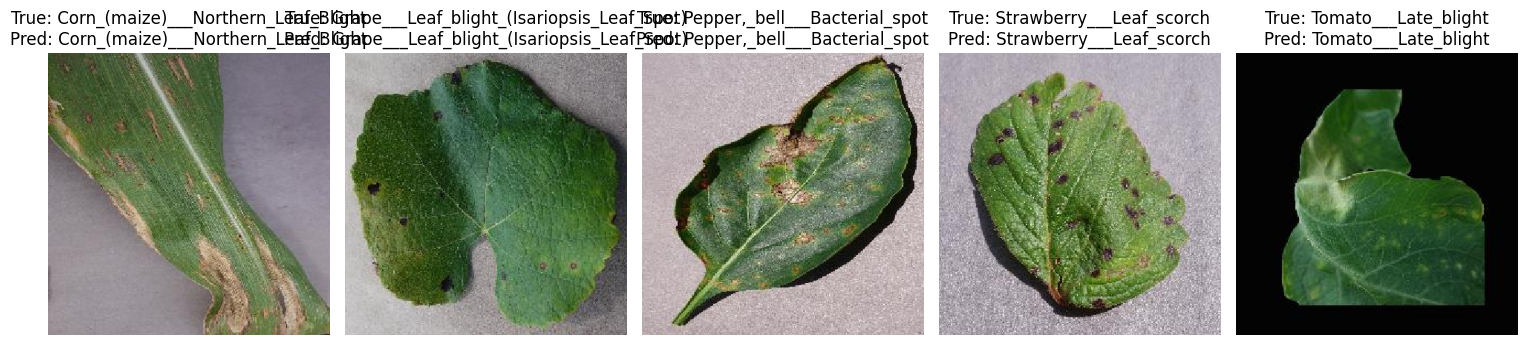

In [43]:
class_indices = train_gen.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
print(index_to_label)

def visualize_predictions_with_filenames(model, test_generator, num_images=5):
    test_gen_iter = iter(test_generator)
    (images, crop_names), true_labels = next(test_gen_iter)

    images = images[:num_images]
    crop_names = crop_names[:num_images]
    true_labels = true_labels[:num_images]

    predictions = model.predict([images, crop_names])
    predicted_labels = np.argmax(predictions, axis=1)

    true_labels_flat = np.argmax(true_labels, axis=1)

    label_encoder = test_generator.label_encoder
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])

        true_label = label_encoder.inverse_transform([true_labels_flat[i]])[0]
        predicted_label = label_encoder.inverse_transform([predicted_labels[i]])[0]

        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions_with_filenames(model, test_gen, num_images=5)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

total_samples = len(test_gen.labels_encoded)

y_pred = []
for batch_x, batch_y in test_gen:
    batch_pred = model.predict(batch_x)
    y_pred.extend(batch_pred)

y_pred = np.array(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_gen.labels_encoded[:len(y_pred_classes)]

report = classification_report(y_true, y_pred_classes, target_names=test_gen.label_encoder.classes_)
print(report)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.label_encoder.classes_, yticklabels=test_gen.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: math domain error

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = len(test_gen.label_encoder.classes_)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_pred_bin = y_pred

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(test_gen.label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")
plt.show()